In [16]:
from pathlib import Path
import numpy as np
from dipy.viz import window, actor, colormap as cmap
from dipy.io.streamline import load_tractogram
import nibabel as nib
import matplotlib.pyplot as plt

In [33]:
SLURM_TMPDIR = Path("/localscratch/knavynde.57350492.0")
dwi_path = Path("/project/6033503/cfmm-bids/Palaniyappan/TOPSY/baseline/correct7T.v0.3.1/prepdwi_v0.0.12c/work/sub-001/dwi/uncorrected_denoise_unring_topup_eddy_regT1/dwi.nii.gz")
t1_path = Path('/scratch/knavynde/topsy/sub-001/anat/sub-001_space-orig_desc-preproc_T1w.nii.gz')
fa_path = Path('/project/6033503/cfmm-bids/Palaniyappan/TOPSY/baseline/correct7T.v0.3.1/prepdwi_v0.0.12c/work/sub-001/dwi/uncorrected_denoise_unring_topup_eddy_regT1/dti_FA.nii.gz')
tracts_path = SLURM_TMPDIR/'tck-tracts'
clusters = SLURM_TMPDIR/'tck-clusters/left'

In [18]:
rand_cluster = next(clusters.iterdir())

In [21]:
sup_f_l_path = tracts_path/"T_Sup-F_left.tck"
tracts = load_tractogram(str(rand_cluster), str(t1_path))

In [22]:
streamlines = tracts.streamlines
tracts_actor = actor.line(streamlines, cmap.line_colors(streamlines))

/localscratch/knavynde.57350492.0/__virtual_environments__/dipy/lib/python3.7/site-packages/fury/utils.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


In [43]:
data = dwi.get_fdata()[..., 0]
mean, std = data[data > 0].mean(), data[data > 0].std()
value_range = (mean - 0.5 * std, mean + 1.5 * std)
slice_actor = actor.slicer(data, dwi.affine, value_range)

In [ ]:
scene = window.Scene()
#slice_actor.display(z=25)
scene.add(tracts_actor)
#scene.add(slice_actor)
scene.reset_camera()
scene.elevation(130)
img = window.snapshot(scene, size=(1000,1000))
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(img)

In [32]:
from dipy.segment.clustering import QuickBundles
from dipy.segment.metric import AveragePointwiseEuclideanMetric, ResampleFeature

feature = ResampleFeature(nb_points=100)
metric = AveragePointwiseEuclideanMetric(feature)

qb = QuickBundles(np.inf, metric=metric)
cluster_bundle = qb.cluster(tracts.streamlines)

In [35]:
import dipy.tracking.streamline as dts

oriented_cluster = dts.orient_by_streamline(tracts.streamlines, cluster_bundle.centroids[0])

In [39]:
import dipy.stats.analysis as dsa

weighted_cluster = dsa.gaussian_weights(oriented_cluster)

In [40]:
fa = nib.load(fa_path)

profile = dsa.afq_profile(fa.get_fdata(), oriented_cluster, fa.affine, weights=weighted_cluster)

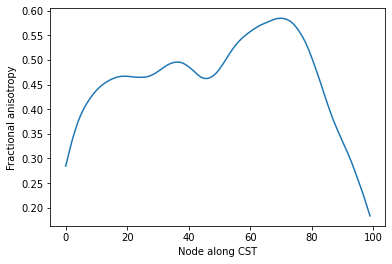

In [47]:
plt.figure()
axes = plt.axes()
axes.set_ylabel("Fractional anisotropy")
axes.set_xlabel("Node along CST")
plt.plot(profile)
